# Convolutional neural networks

In this notebook, we'll put together our convolutional layers to implement a 3-layer CNN.  Then, we'll ask you to implement a CNN that can achieve > 65% validation error on CIFAR-10.

If you have not completed the Spatial BatchNorm Notebook, please see the following description from that notebook:

Please copy and paste your prior implemented code from HW #4 to start this assignment.  If you did not correctly implement the layers in HW #4, you may collaborate with a classmate to use their layer implementations from HW #4.  You may also visit TA or Prof OH to correct your implementation.  

You'll want to copy and paste from HW #4:
    - layers.py for your FC network layers, as well as batchnorm and dropout.
    - layer_utils.py for your combined FC network layers.
    - optim.py for your optimizers.

Be sure to place these in the `nndl/` directory so they're imported correctly.  Note, as announced in class, we will not be releasing our solutions.

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from nndl.cnn import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from nndl.layers import *
from nndl.conv_layers import *
from utils.fast_layers import *
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Three layer CNN

In this notebook, you will implement a three layer CNN.  The `ThreeLayerConvNet` class is in `nndl/cnn.py`.  You'll need to modify that code for this section, including the initialization, as well as the calculation of the loss and gradients.  You should be able to use the building blocks you have either earlier coded or that we have provided.  Be sure to use the fast layers.

The architecture of this CNN will be:

conv - relu - 2x2 max pool - affine - relu - affine - softmax

We won't use batchnorm yet.  You've also done enough of these to know how to debug; use the cells below.

Note: As we are implementing several layers CNN networks. The gradient error can be expected for the `eval_numerical_gradient()` function. If your `W1 max relative error` and `W2 max relative error` are around or below 0.01, they should be acceptable. Other errors should be less than 1e-5. 

In [3]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 0.0039229543503380366
W2 max relative error: 0.0026798963346064695
W3 max relative error: 2.9185899895921736e-05
b1 max relative error: 1.0766309395490432e-05
b2 max relative error: 2.2296973510371742e-07
b3 max relative error: 6.236824694894559e-10


### Overfit small dataset

To check your CNN implementation, let's overfit a small dataset.

In [7]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 20) loss: 2.325183
(Epoch 0 / 10) train acc: 0.210000; val_acc: 0.128000
(Iteration 2 / 20) loss: 2.859539
(Epoch 1 / 10) train acc: 0.210000; val_acc: 0.106000
(Iteration 3 / 20) loss: 2.675631
(Iteration 4 / 20) loss: 2.547447
(Epoch 2 / 10) train acc: 0.280000; val_acc: 0.134000
(Iteration 5 / 20) loss: 2.490574
(Iteration 6 / 20) loss: 1.855074
(Epoch 3 / 10) train acc: 0.330000; val_acc: 0.207000
(Iteration 7 / 20) loss: 1.787314
(Iteration 8 / 20) loss: 1.835055
(Epoch 4 / 10) train acc: 0.580000; val_acc: 0.188000
(Iteration 9 / 20) loss: 1.258561
(Iteration 10 / 20) loss: 1.211132
(Epoch 5 / 10) train acc: 0.590000; val_acc: 0.160000
(Iteration 11 / 20) loss: 1.245911
(Iteration 12 / 20) loss: 1.075001
(Epoch 6 / 10) train acc: 0.620000; val_acc: 0.216000
(Iteration 13 / 20) loss: 1.038730
(Iteration 14 / 20) loss: 1.117598
(Epoch 7 / 10) train acc: 0.820000; val_acc: 0.233000
(Iteration 15 / 20) loss: 0.750677
(Iteration 16 / 20) loss: 0.685618
(Epoch 8 / 10) tr

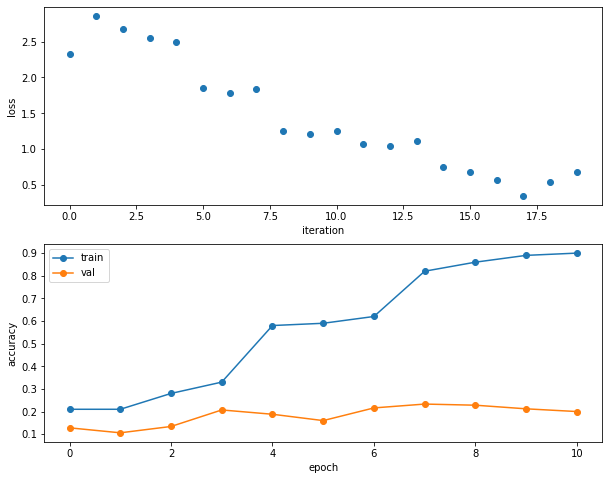

In [8]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the network

Now we train the 3 layer CNN on CIFAR-10 and assess its accuracy.

In [9]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304519
(Epoch 0 / 1) train acc: 0.106000; val_acc: 0.112000
(Iteration 21 / 980) loss: 2.182474
(Iteration 41 / 980) loss: 2.055637
(Iteration 61 / 980) loss: 2.015527
(Iteration 81 / 980) loss: 1.747509
(Iteration 101 / 980) loss: 1.673627
(Iteration 121 / 980) loss: 1.732240
(Iteration 141 / 980) loss: 1.475226
(Iteration 161 / 980) loss: 2.027153
(Iteration 181 / 980) loss: 1.699494
(Iteration 201 / 980) loss: 1.612863
(Iteration 221 / 980) loss: 1.778262
(Iteration 241 / 980) loss: 1.614608
(Iteration 261 / 980) loss: 1.940361
(Iteration 281 / 980) loss: 1.713780
(Iteration 301 / 980) loss: 1.626900
(Iteration 321 / 980) loss: 1.719155
(Iteration 341 / 980) loss: 1.748550
(Iteration 361 / 980) loss: 1.797033
(Iteration 381 / 980) loss: 1.465187
(Iteration 401 / 980) loss: 1.706747
(Iteration 421 / 980) loss: 1.710475
(Iteration 441 / 980) loss: 1.930407
(Iteration 461 / 980) loss: 1.862908
(Iteration 481 / 980) loss: 1.555936
(Iteration 501 / 980) loss: 

# Get > 65% validation accuracy on CIFAR-10.

In the last part of the assignment, we'll now ask you to train a CNN to get better than 65% validation accuracy on CIFAR-10.

### Things you should try:
- Filter size: Above we used 7x7; but VGGNet and onwards showed stacks of 3x3 filters are good.  
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization aafter affine layers. Do your networks train faster?
- Network architecture: Can a deeper CNN do better?  Consider these architectures:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

In [10]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a CNN to achieve greater than 65% validation accuracy
#   on CIFAR-10.
# ================================================================ #

model = ThreeLayerConvNet(weight_scale = 0.001, 
                          hidden_dim = 500, 
                          reg = 0.001, 
                          num_filters = 64,
                          filter_size = 3)

solver = Solver(model, data,
                num_epochs=10, batch_size=500,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.9,
                verbose=True, print_every=15)
solver.train()

# print out the validation and test accuracy
y_val_max = np.argmax(model.loss(data['X_val']), axis=1)
y_test_max = np.argmax(model.loss(data['X_test']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_max == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_max == data['y_test'])))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 980) loss: 2.306750
(Epoch 0 / 10) train acc: 0.104000; val_acc: 0.112000
(Iteration 16 / 980) loss: 1.875861
(Iteration 31 / 980) loss: 1.727335
(Iteration 46 / 980) loss: 1.612002
(Iteration 61 / 980) loss: 1.544193
(Iteration 76 / 980) loss: 1.309349
(Iteration 91 / 980) loss: 1.281215
(Epoch 1 / 10) train acc: 0.581000; val_acc: 0.560000
(Iteration 106 / 980) loss: 1.282992
(Iteration 121 / 980) loss: 1.291973
(Iteration 136 / 980) loss: 1.204956
(Iteration 151 / 980) loss: 1.190480
(Iteration 166 / 980) loss: 1.251083
(Iteration 181 / 980) loss: 1.172586
(Iteration 196 / 980) loss: 1.131847
(Epoch 2 / 10) train acc: 0.620000; val_acc: 0.603000
(Iteration 211 / 980) loss: 1.066770
(Iteration 226 / 980) loss: 1.084402
(Iteration 241 / 980) loss: 1.083245
(Iteration 256 / 980) loss: 1.114625
(Iteration 271 / 980) loss: 1.018875
(Iteration 286 / 980) loss: 1.014123
(Epoch 3 / 10) train acc: 0.661000; val_acc: 0.631000
(Iteration 301 / 980) loss: 1.093395
(Iteration 316 

### CNN.py

In [ ]:
import numpy as np

from nndl.layers import *
from nndl.conv_layers import *
from utils.fast_layers import *
from nndl.layer_utils import *
from nndl.conv_layer_utils import *

import pdb

class ThreeLayerConvNet(object):
  """
  A three-layer convolutional network with the following architecture:
  
  conv - relu - 2x2 max pool - affine - relu - affine - softmax
  
  The network operates on minibatches of data that have shape (N, C, H, W)
  consisting of N images, each with height H and width W and with C input
  channels.
  """
  
  def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
               hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
               dtype=np.float32, use_batchnorm=False):
    """
    Initialize a new network.
    
    Inputs:
    - input_dim: Tuple (C, H, W) giving size of input data
    - num_filters: Number of filters to use in the convolutional layer
    - filter_size: Size of filters to use in the convolutional layer
    - hidden_dim: Number of units to use in the fully-connected hidden layer
    - num_classes: Number of scores to produce from the final affine layer.
    - weight_scale: Scalar giving standard deviation for random initialization
      of weights.
    - reg: Scalar giving L2 regularization strength
    - dtype: numpy datatype to use for computation.
    """
    self.use_batchnorm = use_batchnorm
    self.params = {}
    self.reg = reg
    self.dtype = dtype

    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize the weights and biases of a three layer CNN. To initialize:
    #     - the biases should be initialized to zeros.
    #     - the weights should be initialized to a matrix with entries
    #         drawn from a Gaussian distribution with zero mean and 
    #         standard deviation given by weight_scale.
    # ================================================================ #

    C, H, W = input_dim

    size_W1 = (num_filters, C, filter_size, filter_size)
    size_b1 = num_filters

    Con_output = (num_filters, C, H, W)
    size_W2 = (hidden_dim,(H//2)*(W//2)*num_filters)
    size_b2 = hidden_dim

    size_W3 = (num_classes, hidden_dim)
    size_b3 = num_classes

    self.params['W1'] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W1)
    self.params['b1'] = np.zeros(size_b1)
    self.params['W2'] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W2).T
    self.params['b2'] = np.zeros(size_b2)
    self.params['W3'] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W3).T
    self.params['b3'] = np.zeros(size_b3)



    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)
     
 
  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the three-layer convolutional network.
    
    Input / output: Same API as TwoLayerNet in fc_net.py.
    """
    
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    W3, b3 = self.params['W3'], self.params['b3']
    
    # pass conv_param to the forward pass for the convolutional layer
    filter_size = W1.shape[2]
    conv_param = {'stride': 1, 'pad': (filter_size - 1) / 2}

    # pass pool_param to the forward pass for the max-pooling layer
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    scores = None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the three layer CNN.  Store the output
    #   scores as the variable "scores".
    # ================================================================ #
    
    layer1_out, combined_cache = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param) 
    fc1_out, fc1_cache = affine_relu_forward(layer1_out, W2, b2) 
    scores, fc2_cache = affine_forward(fc1_out, W3, b3) 

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    if y is None:
      return scores
    
    loss, grads = 0, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backward pass of the three layer CNN.  Store the grads
    #   in the grads dictionary, exactly as before (i.e., the gradient of 
    #   self.params[k] will be grads[k]).  Store the loss as "loss", and
    #   don't forget to add regularization on ALL weight matrices.
    # ================================================================ #

    loss, dscores = softmax_loss(scores, y)  
    loss += self.reg * 0.5 * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))

  
    dx3, dw3, db3 = affine_backward(dscores, fc2_cache)
    dx2, dw2, db2 = affine_relu_backward(dx3, fc1_cache)
    dx1, dw1, db1 = conv_relu_pool_backward(dx2, combined_cache)

    grads['W3'], grads['b3'] = dw3 + self.reg * W3, db3
    grads['W2'], grads['b2'] = dw2 + self.reg * W2, db2
    grads['W1'], grads['b1'] = dw1 + self.reg * W1, db1

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grads
  
  
pass


# Conv_layers.py

In [ ]:
import numpy as np
from nndl.layers import *
import pdb


def conv_forward_naive(x, w, b, conv_param):
  """
  A naive implementation of the forward pass for a convolutional layer.

  The input consists of N data points, each with C channels, height H and width
  W. We convolve each input with F different filters, where each filter spans
  all C channels and has height HH and width HH.

  Input:
  - x: Input data of shape (N, C, H, W)
  - w: Filter weights of shape (F, C, HH, WW)
  - b: Biases, of shape (F,)
  - conv_param: A dictionary with the following keys:
    - 'stride': The number of pixels between adjacent receptive fields in the
      horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input.

  Returns a tuple of:
  - out: Output data, of shape (N, F, H', W') where H' and W' are given by
    H' = 1 + (H + 2 * pad - HH) / stride
    W' = 1 + (W + 2 * pad - WW) / stride
  - cache: (x, w, b, conv_param)
  """
  out = None
  pad = conv_param['pad']
  stride = conv_param['stride']

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the forward pass of a convolutional neural network.
  #   Store the output as 'out'.
  #   Hint: to pad the array, you can use the function np.pad.
  # ================================================================ #
  
  N, C, H, W = x.shape    
  F, C, HH, WW = w.shape  

  padded_x = (np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant'))  
  out_height = np.int(((H + 2 * pad - HH) / stride) + 1)  
  out_width = np.int(((W + 2 * pad - WW) / stride) + 1)  
  out = np.zeros([N, F, out_height, out_width])  

  for img in range(N):  
    for kernal in range(F):  
      for row in range(out_height):  
        for col in range(out_width):  
          out[img, kernal, row, col] = np.sum(w[kernal, ...] * \
                                              padded_x[img, :, row*stride:row*stride+HH, col*stride:col*stride+WW]) + b[kernal]

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
    
  cache = (x, w, b, conv_param)
  return out, cache


def conv_backward_naive(dout, cache):
  """
  A naive implementation of the backward pass for a convolutional layer.

  Inputs:
  - dout: Upstream derivatives.
  - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

  Returns a tuple of:
  - dx: Gradient with respect to x
  - dw: Gradient with respect to w
  - db: Gradient with respect to b
  """
  dx, dw, db = None, None, None

  N, F, out_height, out_width = dout.shape
  x, w, b, conv_param = cache
  
  stride, pad = [conv_param['stride'], conv_param['pad']]
  xpad = np.pad(x, ((0,0), (0,0), (pad,pad), (pad,pad)), mode='constant')
  num_filts, _, f_height, f_width = w.shape

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the backward pass of a convolutional neural network.
  #   Calculate the gradients: dx, dw, and db.
  # ================================================================ #

  _, _, H, W = x.shape  # [N, 3, 32, 32]
    
  dx_temp = np.zeros_like(xpad)  # initial to all zeros
  dw = np.zeros_like(w)
  db = np.zeros_like(b)

  # Calculate dB.
  for kernal in range(F):
    db[kernal] += np.sum(dout[:, kernal, :, :])  # sum all N img's kernal -> [32, 32], then sum all 32x32 elements -> 1 scalar
  
  # Calculate dw.
  for img in range(N):  # for each image
    for kernal in range(F):  # for each kernal
      for row in range(out_height):  # from top to bottom
        for col in range(out_width):  # from left to right
          dw[kernal, ...] += dout[img, kernal, row, col] * xpad[img, :, row*stride:row*stride+f_height, col*stride:col*stride+f_width]
  
  # Calculate dx.
  for img in range(N):  # for each image
    for kernal in range(F):  # for each kernal
      for row in range(out_height):  # from top to bottom
        for col in range(out_width):  # from left to right
          dx_temp[img, :, row*stride:row*stride+f_height, col*stride:col*stride+f_width] += dout[img, kernal, row,col] * w[kernal, ...]
  
  dx = dx_temp[:, :, pad:H+pad, pad:W+pad]


  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #

  return dx, dw, db


def max_pool_forward_naive(x, pool_param):
  """
  A naive implementation of the forward pass for a max pooling layer.

  Inputs:
  - x: Input data, of shape (N, C, H, W)
  - pool_param: dictionary with the following keys:
    - 'pool_height': The height of each pooling region
    - 'pool_width': The width of each pooling region
    - 'stride': The distance between adjacent pooling regions

  Returns a tuple of:
  - out: Output data
  - cache: (x, pool_param)
  """
  out = None
  
  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the max pooling forward pass.
  # ================================================================ #

  pool_height = pool_param.get('pool_height')
  pool_width = pool_param.get('pool_width')
  stride = pool_param.get('stride')
  N, C, H, W = x.shape   

  out_height = np.int(((H - pool_height) / stride) + 1)  
  out_width = np.int(((W - pool_width) / stride) + 1)    
  out = np.zeros([N, C, out_height, out_width])

  for img in range(N): 
    for channel in range(C): 
      for row in range(out_height): 
        for col in range(out_width): 
          out[img, channel, row, col] = np.max(x[img, channel, row*stride:row*stride+pool_height, col*stride:col*stride+pool_width])

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ # 
  cache = (x, pool_param)
  return out, cache

def max_pool_backward_naive(dout, cache):
  """
  A naive implementation of the backward pass for a max pooling layer.

  Inputs:
  - dout: Upstream derivatives
  - cache: A tuple of (x, pool_param) as in the forward pass.

  Returns:
  - dx: Gradient with respect to x
  """
  dx = None
  x, pool_param = cache
  pool_height, pool_width, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the max pooling backward pass.
  # ================================================================ #
  
  N, C, H, W = x.shape  
  _, _, dout_height, dout_width = dout.shape
  dx = np.zeros_like(x)

  for img in range(N): 
    for channel in range(C): 
      for row in range(dout_height): 
        for col in range(dout_width): 
          max_idx = np.argmax(x[img, channel, row*stride:row*stride+pool_height, col*stride:col*stride+pool_width])
          max_position = np.unravel_index(max_idx, [pool_height, pool_width])
          dx[img, channel, row*stride:row*stride+pool_height, col*stride:col*stride+pool_width][max_position] = dout[img, channel, row, col]


  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ # 

  return dx

def spatial_batchnorm_forward(x, gamma, beta, bn_param):
  """
  Computes the forward pass for spatial batch normalization.
  
  Inputs:
  - x: Input data of shape (N, C, H, W)
  - gamma: Scale parameter, of shape (C,)
  - beta: Shift parameter, of shape (C,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance. momentum=0 means that
      old information is discarded completely at every time step, while
      momentum=1 means that new information is never incorporated. The
      default of momentum=0.9 should work well in most situations.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features
    
  Returns a tuple of:
  - out: Output data, of shape (N, C, H, W)
  - cache: Values needed for the backward pass
  """
  out, cache = None, None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the spatial batchnorm forward pass.
  #
  #   You may find it useful to use the batchnorm forward pass you 
  #   implemented in HW #4.
  # ================================================================ #
  
  N, C, H, W = x.shape  # [N, 3, 32, 32]
  x_transpose = x.transpose(0, 2, 3, 1)
  x_reshape = np.reshape(x_transpose, (N*H*W, C)) # reshape to 2D to do batchnorm
  out_2d, cache = batchnorm_forward(x_reshape, gamma, beta, bn_param) 
  out = out_2d.reshape((N, H, W, C)).transpose(0, 3, 1, 2) # reshape back


  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ # 

  return out, cache


def spatial_batchnorm_backward(dout, cache):
  """
  Computes the backward pass for spatial batch normalization.
  
  Inputs:
  - dout: Upstream derivatives, of shape (N, C, H, W)
  - cache: Values from the forward pass
  
  Returns a tuple of:
  - dx: Gradient with respect to inputs, of shape (N, C, H, W)
  - dgamma: Gradient with respect to scale parameter, of shape (C,)
  - dbeta: Gradient with respect to shift parameter, of shape (C,)
  """
  dx, dgamma, dbeta = None, None, None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the spatial batchnorm backward pass.
  #
  #   You may find it useful to use the batchnorm forward pass you 
  #   implemented in HW #4.
  # ================================================================ #
  
  dx = np.zeros_like(dout)
  N, C, H, W = dout.shape
  dout_transpose = dout.transpose((0, 2, 3, 1))
  dout_reshape = np.reshape(dout_transpose, (N*H*W, C)) # reshape to 2D to do batchnorm
  dx_2d, dgamma, dbeta = batchnorm_backward(dout_reshape, cache)
  dx = dx_2d.reshape((N, H, W, C)).transpose(0, 3, 1, 2) # reshape back

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ # 

  return dx, dgamma, dbeta

# Layers.py

In [ ]:
import numpy as np
import pdb

def affine_forward(x, w, b):
  """
  Computes the forward pass for an affine (fully-connected) layer.

  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.

  Inputs:
  - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
  - w: A numpy array of weights, of shape (D, M)
  - b: A numpy array of biases, of shape (M,)

  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """

  # ================================================================ #
  # YOUR CODE HERE:
  #   Calculate the output of the forward pass.  Notice the dimensions
  #   of w are D x M, which is the transpose of what we did in earlier
  #   assignments.
  # ================================================================ #

  
  x_reshape = x.reshape((x.shape[0], w.shape[0])) # N * D
  out = x_reshape.dot(w) + b.reshape((1, b.shape[0])) # N * M
   
  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #

  cache = (x, w, b)
  return out, cache


def affine_backward(dout, cache):
  """
  Computes the backward pass for an affine layer.

  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)

  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Calculate the gradients for the backward pass.
  # ================================================================ #

  
  x_reshape = np.reshape(x, (x.shape[0], w.shape[0]))
  dx_reshape = dout.dot(w.T)
  dx = np.reshape(dx_reshape, x.shape) # N * D
  dw = x_reshape.T.dot(dout) # D * M
  db = dout.T.dot(np.ones(x.shape[0]))  # M * 1

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #

  return dx, dw, db

def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).

  Input:
  - x: Inputs, of any shape

  Returns a tuple of:
  - out: Output, of the same shape as x
  - cache: x
  """
  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the ReLU forward pass.
  # ================================================================ #
  
  out = np.maximum(0, x)

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #

  cache = x
  return out, cache


def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).

  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout

  Returns:
  - dx: Gradient with respect to x
  """
  x = cache

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the ReLU backward pass
  # ================================================================ #

  dx = (x > 0) * (dout)

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #

  return dx

def batchnorm_forward(x, gamma, beta, bn_param):
  """
  Forward pass for batch normalization.

  During training the sample mean and (uncorrected) sample variance are
  computed from minibatch statistics and used to normalize the incoming data.
  During training we also keep an exponentially decaying running mean of the mean
  and variance of each feature, and these averages are used to normalize data
  at test-time.

  At each timestep we update the running averages for mean and variance using
  an exponential decay based on the momentum parameter:

  running_mean = momentum * running_mean + (1 - momentum) * sample_mean
  running_var = momentum * running_var + (1 - momentum) * sample_var

  Note that the batch normalization paper suggests a different test-time
  behavior: they compute sample mean and variance for each feature using a
  large number of training images rather than using a running average. For
  this implementation we have chosen to use running averages instead since
  they do not require an additional estimation step; the torch7 implementation
  of batch normalization also uses running averages.

  Input:
  - x: Data of shape (N, D)
  - gamma: Scale parameter of shape (D,)
  - beta: Shift paremeter of shape (D,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

  Returns a tuple of:
  - out: of shape (N, D)
  - cache: A tuple of values needed in the backward pass
  """
  mode = bn_param['mode']
  eps = bn_param.get('eps', 1e-5)
  momentum = bn_param.get('momentum', 0.9)

  N, D = x.shape
  running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
  running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

  out, cache = None, None
  if mode == 'train':

    # ================================================================ #
    # YOUR CODE HERE:
    #   A few steps here:
    #     (1) Calculate the running mean and variance of the minibatch.
    #     (2) Normalize the activations with the running mean and variance.
    #     (3) Scale and shift the normalized activations.  Store this
    #         as the variable 'out'
    #     (4) Store any variables you may need for the backward pass in
    #         the 'cache' variable.
    # ================================================================ #

    minibatch_mean = np.mean(x, axis=0)
    minibatch_var = np.var(x, axis=0)
    x_normalize = (x - minibatch_mean) / np.sqrt(minibatch_var + eps)
    out = gamma * x_normalize + beta
    
    running_mean = momentum * running_mean + (1 - momentum) * minibatch_mean
    running_var = momentum * running_var + (1 - momentum) * minibatch_var
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    cache = {
      'minibatch_var': minibatch_var,
      'x_centralize': (x - minibatch_mean),
      'x_normalize': x_normalize,
      'gamma': gamma,
      'eps': eps
    }

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  elif mode == 'test':

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the testing time normalized activation.  Normalize using
    #   the running mean and variance, and then scale and shift appropriately.
    #   Store the output as 'out'.
    # ================================================================ #

    out = gamma * (x - running_mean) / np.sqrt(running_var + eps) + beta
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  else:
    raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

  # Store the updated running means back into bn_param
  bn_param['running_mean'] = running_mean
  bn_param['running_var'] = running_var

  return out, cache

def batchnorm_backward(dout, cache):
  """
  Backward pass for batch normalization.

  For this implementation, you should write out a computation graph for
  batch normalization on paper and propagate gradients backward through
  intermediate nodes.

  Inputs:
  - dout: Upstream derivatives, of shape (N, D)
  - cache: Variable of intermediates from batchnorm_forward.

  Returns a tuple of:
  - dx: Gradient with respect to inputs x, of shape (N, D)
  - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
  - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
  """
  dx, dgamma, dbeta = None, None, None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
  # ================================================================ #

  N = dout.shape[0]
  minibatch_var = cache.get('minibatch_var')
  x_centralize = cache.get('x_centralize')
  x_normalize = cache.get('x_normalize')
  gamma = cache.get('gamma')
  eps = cache.get('eps')
  
  # calculate dx
  dxhat = dout * gamma
  dxmu1 = dxhat / np.sqrt(minibatch_var + eps)
  sqrt_var = np.sqrt(minibatch_var + eps)
  dsqrt_var = -np.sum(dxhat * x_centralize, axis=0) / (sqrt_var**2)
  dvar = dsqrt_var * 0.5 / sqrt_var
  dxmu2 = 2 * x_centralize * dvar * np.ones_like(dout) / N
  dx1 = dxmu1 + dxmu2
  dx2 = -np.sum(dx1, axis=0) * np.ones_like(dout) / N
  dx = dx1 + dx2
  
  # calculate dbeta and dgamma
  dbeta = np.sum(dout, axis=0)
  dgamma = np.sum(dout * x_normalize, axis=0)

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #

  return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
  """
  Performs the forward pass for (inverted) dropout.

  Inputs:
  - x: Input data, of any shape
  - dropout_param: A dictionary with the following keys:
    - p: Dropout parameter. We drop each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
      if the mode is test, then just return the input.
    - seed: Seed for the random number generator. Passing seed makes this
      function deterministic, which is needed for gradient checking but not in
      real networks.

  Outputs:
  - out: Array of the same shape as x.
  - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
    mask that was used to multiply the input; in test mode, mask is None.
  """
  p, mode = dropout_param['p'], dropout_param['mode']
  if 'seed' in dropout_param:
    np.random.seed(dropout_param['seed'])

  mask = None
  out = None

  if mode == 'train':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout forward pass during training time.
    #   Store the masked and scaled activations in out, and store the
    #   dropout mask as the variable mask.
    # ================================================================ #

    mask = (np.random.random_sample(x.shape) >= p) / (1 - p)
    out = x * mask
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  elif mode == 'test':

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout forward pass during test time.
    # ================================================================ #
    out = x
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  cache = (dropout_param, mask)
  out = out.astype(x.dtype, copy=False)

  return out, cache

def dropout_backward(dout, cache):
  """
  Perform the backward pass for (inverted) dropout.

  Inputs:
  - dout: Upstream derivatives, of any shape
  - cache: (dropout_param, mask) from dropout_forward.
  """
  dropout_param, mask = cache
  mode = dropout_param['mode']

  dx = None
  if mode == 'train':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout backward pass during training time.
    # ================================================================ #
    
    dx = dout * mask

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
  elif mode == 'test':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout backward pass during test time.
    # ================================================================ #
    
    dx = dout
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
  return dx

def svm_loss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[np.arange(N), y]
  margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  num_pos = np.sum(margins > 0, axis=1)
  dx = np.zeros_like(x)
  dx[margins > 0] = 1
  dx[np.arange(N), y] -= num_pos
  dx /= N
  return loss, dx


def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """

  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx
